### Import

In [7]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import os
from pprint import pprint

from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
    roc_auc_score,
    roc_curve
)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from tqdm import tqdm

import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostClassifier

In [8]:
import platform
from matplotlib import rc

# 운영 체제에 따라 폰트 설정
if platform.system() == 'Windows':  # Windows 환경
    rc('font', family='Malgun Gothic')  # 맑은 고딕

# 음수 표시 가능하도록 설정
plt.rcParams['axes.unicode_minus'] = False

반복적으로 쓰는 함수툴

In [9]:
def plot_box(df, col_name):
    """
    주어진 데이터프레임과 열 이름에 대해 박스 플롯을 그리는 함수.

    Parameters:
    dataframe (pd.DataFrame): 데이터프레임
    column_name (str): 열 이름
    """
    plt.figure(figsize=(7, 4))
    plt.boxplot(df[col_name], vert=False)
    plt.xlabel(col_name)
    plt.title(f'Box Plot of {col_name}')
    plt.show()

def value_counts_ratio(df, col_name, target_name='임신 성공 여부'):
    """
    주어진 데이터프레임의 특정 열에 대해 각 값마다 타겟 변수의 비율과 갯수, 총 갯수를 출력하는 함수.

    Parameters:
    df (pd.DataFrame): 데이터프레임
    col_name (str): 열 이름
    target_name (str): 타겟 변수 이름
    """
    # 각 값마다 타겟 변수의 비율 계산
    value_counts = df.groupby(col_name)[target_name].value_counts(normalize=True).unstack().fillna(0)
    
    # 각 값마다 타겟 변수의 갯수 계산
    counts = df.groupby(col_name)[target_name].value_counts().unstack().fillna(0)
    
    # 각 값마다 총 갯수 계산
    total_counts = df[col_name].value_counts().rename('Total_Count')
    
    # 비율과 갯수를 합침
    result = value_counts.join(counts, lsuffix='_ratio', rsuffix='_count')
    
    # 총 갯수를 합침
    result = result.join(total_counts, on=col_name)
    
    # 출력 형식 조정
    result.index.name = 'variable'
    print(f"\n{col_name}별 {target_name} 비율 및 갯수\n")
    print(result.rename(columns=lambda x: x.split('_')[0]))

def summarize_group(df, group_by_columns):
    # 데이터프레임을 그룹화
    grouped_df = df.groupby(group_by_columns)
    
    # 결과를 저장할 리스트 초기화
    results = []
    
    # 그룹화된 데이터프레임의 내용을 확인하는 코드
    for name, group in grouped_df:
        # 그룹의 갯수 계산
        group_count = group.shape[0]
        
        # '임신 성공 여부' 변수의 '임신 성공 여부' 비율과 갯수 계산
        adnormal_count = group['임신 성공 여부'].value_counts().get('임신 성공 여부', 0)
        adnormal_ratio = adnormal_count / group_count
        
        # 결과 리스트에 추가
        results.append([name, adnormal_count, adnormal_ratio, group_count])
    
    # 결과 리스트를 데이터프레임으로 변환
    results_df = pd.DataFrame(results, columns=['group', "'임신 성공 여부' count", 'ratio', 'Total'])
    
    # 그룹화된 변수들의 이름을 제목행으로 출력
    print(f"Grouped by: {', '.join(group_by_columns)}")
    print()
    # 데이터프레임 출력
    print(results_df)

# 예시코드
# summarize_grouped_data(train_data, ['1st Pressure Collect Result_AutoClave', '1st Pressure Unit Time_AutoClave'])

def plot_ratio(df, group_by_column, target_column='임신 성공 여부', abnormal_value='임신 성공 여부'):
    # 데이터프레임을 그룹화
    grouped_df = df.groupby(group_by_column)
    
    # 결과를 저장할 리스트 초기화
    results = []
    
    # 그룹화된 데이터프레임의 내용을 확인하는 코드
    for name, group in grouped_df:
        # 그룹의 갯수 계산
        group_count = group.shape[0]
        
        # '임신 성공 여부' 변수의 '임신 성공 여부' 비율과 갯수 계산
        abnormal_count = group[target_column].value_counts().get(abnormal_value, 0)
        abnormal_ratio = abnormal_count / group_count
        
        # 결과 리스트에 추가
        results.append([name, abnormal_count, abnormal_ratio, group_count])
    
    # 결과 리스트를 데이터프레임으로 변환
    results_df = pd.DataFrame(results, columns=['group', f"'{abnormal_value}' count", 'ratio', 'Total'])
    
    # 그래프 크기 설정
    plt.figure(figsize=(10, 5))
    
    # 막대 그래프 생성
    ax = results_df.plot(kind='bar', x='group', y='ratio', legend=False)
    
    # 각 막대 위에 임신 성공 여부 갯수와 총 갯수 표시
    for i, (abnormal_count, total) in enumerate(zip(results_df[f"'{abnormal_value}' count"], results_df['Total'])):
        ax.text(i, results_df['ratio'][i], f'{abnormal_count} ({total})', ha='center', va='bottom', fontsize=8)
    
     # 그래프 제목 및 축 레이블 설정
    ax.set_title(f'{abnormal_value} Ratio by {group_by_column}')
    ax.set_xlabel(group_by_column)
    ax.set_ylabel(f'{abnormal_value} Ratio')
   
    # 그래프 출력
    plt.show()

def plot_ratio_boxplot(data, time_ratio_column, target_column='임신 성공 여부'):
    # 그래프 스타일 설정
    sns.set(style="whitegrid")

    # 그래프 그리기
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=time_ratio_column, y=target_column, data=data)

    # 그래프 제목 및 레이블 설정
    plt.title(f'{time_ratio_column} vs {target_column}')
    plt.xlabel(time_ratio_column)
    plt.ylabel(target_column)

    # 그래프 출력
    plt.show()

# 함수 호출 예제
#plot_ratio_boxplot(train_data, 'time_ratio_Dam')

In [6]:
value_counts_ratio(train, '시술 당시 나이')


시술 당시 나이별 임신 성공 여부 비율 및 갯수

                 0         1        0        1   Total
variable                                              
만18-34세   0.677378  0.322622  69415.0  33061.0  102476
만35-37세   0.721599  0.278401  41694.0  16086.0   57780
만38-39세   0.782862  0.217138  30725.0   8522.0   39247
만40-42세   0.840607  0.159393  31395.0   5953.0   37348
만43-44세   0.881988  0.118012  10807.0   1446.0   12253
만45-50세   0.832321  0.167679   5758.0   1160.0    6918
알 수 없음    1.000000  0.000000    329.0      0.0     329


### Data Load

In [5]:
train = pd.read_csv('../data/train.csv').drop(columns=['ID'])
test = pd.read_csv('../data/test.csv').drop(columns=['ID'])

In [86]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 256351 entries, 0 to 256350
Data columns (total 68 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   시술 시기 코드               256351 non-null  object 
 1   시술 당시 나이               256351 non-null  object 
 2   임신 시도 또는 마지막 임신 경과 연수  9370 non-null    float64
 3   시술 유형                  256351 non-null  object 
 4   특정 시술 유형               256349 non-null  object 
 5   배란 자극 여부               256351 non-null  int64  
 6   배란 유도 유형               256351 non-null  object 
 7   단일 배아 이식 여부            250060 non-null  float64
 8   착상 전 유전 검사 사용 여부       2718 non-null    float64
 9   착상 전 유전 진단 사용 여부       250060 non-null  float64
 10  남성 주 불임 원인             256351 non-null  int64  
 11  남성 부 불임 원인             256351 non-null  int64  
 12  여성 주 불임 원인             256351 non-null  int64  
 13  여성 부 불임 원인             256351 non-null  int64  
 14  부부 주 불임 원인             256351 non-nu

In [87]:
train['임신 성공 여부'].value_counts()

0    190123
1     66228
Name: 임신 성공 여부, dtype: int64

In [88]:
train['임신 시도 또는 마지막 임신 경과 연수'].value_counts()

7.0     1214
8.0     1176
9.0     1023
6.0      991
10.0     947
11.0     701
5.0      692
12.0     510
13.0     481
14.0     331
4.0      305
15.0     254
16.0     202
17.0     140
18.0     106
3.0       89
19.0      86
20.0      83
2.0       21
0.0       12
1.0        6
Name: 임신 시도 또는 마지막 임신 경과 연수, dtype: int64

In [89]:
train.head(1)

,시술 시기 코드,시술 당시 나이,임신 시도 또는 마지막 임신 경과 연수,시술 유형,특정 시술 유형,배란 자극 여부,배란 유도 유형,단일 배아 이식 여부,착상 전 유전 검사 사용 여부,착상 전 유전 진단 사용 여부,...,기증 배아 사용 여부,대리모 여부,PGD 시술 여부,PGS 시술 여부,난자 채취 경과일,난자 해동 경과일,난자 혼합 경과일,배아 이식 경과일,배아 해동 경과일,임신 성공 여부
0,TRZKPL,만18-34세,NaN,IVF,ICSI,1,기록되지 않은 시행,0.0,NaN,0.0,...,0.0,0.0,NaN,NaN,0.0,NaN,0.0,3.0,NaN,0


In [90]:
train['착상 전 유전 검사 사용 여부'].value_counts()

1.0    2718
Name: 착상 전 유전 검사 사용 여부, dtype: int64

In [91]:
X = train.drop('임신 성공 여부', axis=1)
y = train['임신 성공 여부']

### Data Pre-processing

In [92]:
categorical_columns = [
    "시술 시기 코드",
    "시술 당시 나이",
    "시술 유형",
    "특정 시술 유형",
    "배란 자극 여부",
    "배란 유도 유형",
    "단일 배아 이식 여부",
    "착상 전 유전 검사 사용 여부",
    "착상 전 유전 진단 사용 여부",
    "남성 주 불임 원인",
    "남성 부 불임 원인",
    "여성 주 불임 원인",
    "여성 부 불임 원인",
    "부부 주 불임 원인",
    "부부 부 불임 원인",
    "불명확 불임 원인",
    "불임 원인 - 난관 질환",
    "불임 원인 - 남성 요인",
    "불임 원인 - 배란 장애",
    "불임 원인 - 여성 요인",
    "불임 원인 - 자궁경부 문제",
    "불임 원인 - 자궁내막증",
    "불임 원인 - 정자 농도",
    "불임 원인 - 정자 면역학적 요인",
    "불임 원인 - 정자 운동성",
    "불임 원인 - 정자 형태",
    "배아 생성 주요 이유",
    "총 시술 횟수",
    "클리닉 내 총 시술 횟수",
    "IVF 시술 횟수",
    "DI 시술 횟수",
    "총 임신 횟수",
    "IVF 임신 횟수",
    "DI 임신 횟수",
    "총 출산 횟수",
    "IVF 출산 횟수",
    "DI 출산 횟수",
    "난자 출처",
    "정자 출처",
    "난자 기증자 나이",
    "정자 기증자 나이",
    "동결 배아 사용 여부",
    "신선 배아 사용 여부",
    "기증 배아 사용 여부",
    "대리모 여부",
    "PGD 시술 여부",
    "PGS 시술 여부"
]

In [93]:
# 카테고리형 컬럼들을 문자열로 변환
for col in categorical_columns:
    X[col] = X[col].astype(str)
    test[col] = test[col].astype(str)

In [94]:
ordinal_encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

X_train_encoded = X.copy()
X_train_encoded[categorical_columns] = ordinal_encoder.fit_transform(X[categorical_columns])

X_test_encoded = test.copy()
X_test_encoded[categorical_columns] = ordinal_encoder.transform(test[categorical_columns])

In [95]:
numeric_columns = [
    "임신 시도 또는 마지막 임신 경과 연수",
    "총 생성 배아 수",
    "미세주입된 난자 수",
    "미세주입에서 생성된 배아 수",
    "이식된 배아 수",
    "미세주입 배아 이식 수",
    "저장된 배아 수",
    "미세주입 후 저장된 배아 수",
    "해동된 배아 수",
    "해동 난자 수",
    "수집된 신선 난자 수",
    "저장된 신선 난자 수",
    "혼합된 난자 수",
    "파트너 정자와 혼합된 난자 수",
    "기증자 정자와 혼합된 난자 수",
    "난자 채취 경과일",
    "난자 해동 경과일",
    "난자 혼합 경과일",
    "배아 이식 경과일",
    "배아 해동 경과일"
]

In [96]:
X_train_encoded[numeric_columns] = X_train_encoded[numeric_columns].fillna(0)
X_test_encoded[numeric_columns] = X_test_encoded[numeric_columns].fillna(0)

### Train

In [97]:
# model = ExtraTreesClassifier(random_state=42)

# model.fit(X_train_encoded, y)

In [98]:
import lightgbm as lgb

# 모델 초기화
model = lgb.LGBMClassifier(random_state=42)

# 모델 학습
model.fit(X_train_encoded, y)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 66228, number of negative: 190123
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019068 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 720
[LightGBM] [Info] Number of data points in the train set: 256351, number of used features: 62
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.258349 -> initscore=-1.054568
[LightGBM] [Info] Start training from score -1.054568


LGBMClassifier(random_state=42)

### Predict

In [99]:
pred_proba = model.predict_proba(X_test_encoded)[:, 1]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 53102, number of negative: 151978
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.020320 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 716
[LightGBM] [Info] Number of data points in the train set: 205080, number of used features: 62
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.258933 -> initscore=-1.051521
[LightGBM] [Info] Start training from score -1.051521
AUC: 0.7386


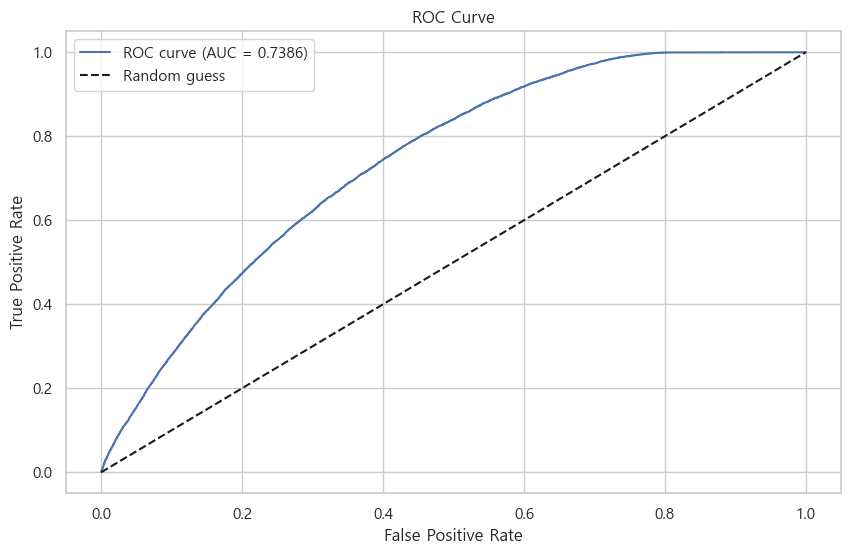

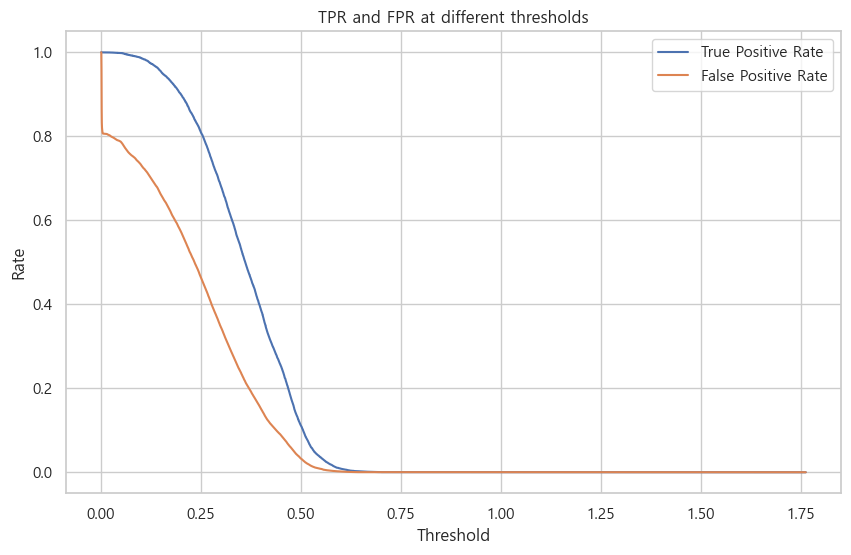

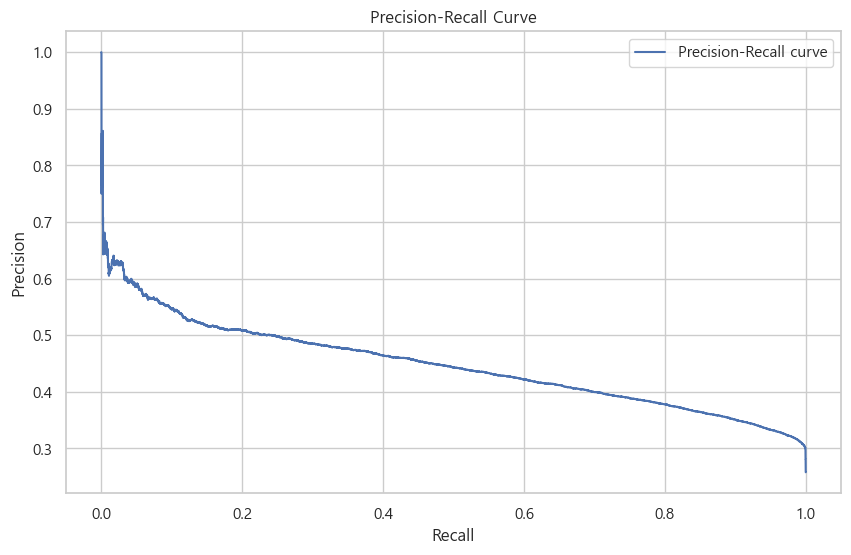

F1 Score at threshold 0.5: 0.1846


In [104]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, f1_score
import lightgbm as lgb
import matplotlib.pyplot as plt

# 학습용 데이터와 검증용 데이터로 분할
X_train, X_val, y_train, y_val = train_test_split(X_train_encoded, y, test_size=0.2, random_state=42)

# 모델 초기화
model = lgb.LGBMClassifier(random_state=42)

# 모델 학습
model.fit(X_train, y_train)

# 검증 데이터에 대한 예측 확률 계산
pred_proba = model.predict_proba(X_val)[:, 1]

# AUC 값 계산
auc = roc_auc_score(y_val, pred_proba)
print(f'AUC: {auc:.4f}')

# ROC 곡선 계산
fpr, tpr, thresholds = roc_curve(y_val, pred_proba)

# ROC 곡선 시각화
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='best')
plt.show()

# 임계값에 따른 TPR, FPR 시각화
plt.figure(figsize=(10, 6))
plt.plot(thresholds, tpr, label='True Positive Rate')
plt.plot(thresholds, fpr, label='False Positive Rate')
plt.xlabel('Threshold')
plt.ylabel('Rate')
plt.title('TPR and FPR at different thresholds')
plt.legend(loc='best')
plt.show()

# Precision-Recall 곡선 계산
precision, recall, pr_thresholds = precision_recall_curve(y_val, pred_proba)

# Precision-Recall 곡선 시각화
plt.figure(figsize=(10, 6))
plt.plot(recall, precision, label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='best')
plt.show()

# F1 점수 계산
# 임계값을 0.5로 설정하여 이진 분류
threshold = 0.5
pred_binary = (pred_proba >= threshold).astype(int)
f1 = f1_score(y_val, pred_binary)
print(f'F1 Score at threshold {threshold}: {f1:.4f}')

### Submission

In [54]:
sample_submission = pd.read_csv('../data/sample_submission.csv')
sample_submission['probability'] = pred_proba

In [ ]:
sample_submission.to_csv('./baseline_submit_xx.csv', index=False)